Step 1. Build a CaF₂ Cluster with ASE

In [6]:
from ase import Atoms
from ase.build import make_supercell
from ase.io import write
from ase.build import bulk
from ase.cluster import wulff_construction
from ase.io import write, read

# Build CaF2 fluorite unit cell
caf2 = bulk('CaF2', 'fluorite', a=5.46)  # experimental lattice ~5.46 Å

# Cut out a small cluster (~1 nm) with CaF2 stoichiometry
# (Alternative: just take supercell and slice central atoms)
cluster = caf2.repeat((2,2,2))  # 2x2x2 supercell
cluster.center(vacuum=6.0)

write("caf2_cluster.xyz", cluster)
atoms = read("caf2_cluster.xyz")
print(f"Atoms: {len(atoms)}")
print(f"Formula: {atoms.get_chemical_formula()}")
print(f"Cell dimensions (Å): {atoms.cell.cellpar()}")
print("Cluster with", len(cluster), "atoms written to caf2_cluster.xyz")

Atoms: 24
Formula: Ca8F16
Cell dimensions (Å): [21.45334375 21.45334375 21.45334375 60.         60.         60.        ]
Cluster with 24 atoms written to caf2_cluster.xyz


Step 2. Build a CaF₂:Er Cluster with ASE

In [7]:
from ase.build import bulk
from ase.io import write
import numpy as np

# Step 1: Build CaF2 fluorite cell
caf2 = bulk('CaF2', 'fluorite', a=5.46)

# Step 2: Make a small cluster (supercell with vacuum)
cluster = caf2.repeat((2,2,2))
cluster.center(vacuum=6.0)

# Step 3: Substitute one Ca -> Er to get Ca3:Er ratio in cluster
symbols = cluster.get_chemical_symbols()
ca_indices = [i for i, s in enumerate(symbols) if s == "Ca"]

if len(ca_indices) < 4:
    raise RuntimeError("Not enough Ca atoms to make Ca3:Er substitution!")

# Replace the 4th Ca with Er
symbols[ca_indices[3]] = "Er"
cluster.set_chemical_symbols(symbols)

# Step 4: Save
write("caf2_er_cluster.xyz", cluster)
atoms = read("caf2_er_cluster.xyz")
print(f"Atoms: {len(atoms)}")
print(f"Formula: {atoms.get_chemical_formula()}")
print(f"Cell dimensions (Å): {atoms.cell.cellpar()}")
print("Cluster with", len(cluster), "atoms written to caf2_er_cluster.xyz")

Atoms: 24
Formula: Ca7ErF16
Cell dimensions (Å): [21.45334375 21.45334375 21.45334375 60.         60.         60.        ]
Cluster with 24 atoms written to caf2_er_cluster.xyz


3. Simulate

In [11]:
import os, sys, time, inspect, psutil
# Determine project root (Q-UCSpec) and unified output directory
_project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
OUT_DIR = os.path.join(_project_root, "spectra-results")
os.makedirs(OUT_DIR, exist_ok=True)
# Centralized data directory for all CSV outputs
DATA_DIR = os.path.join(_project_root, "data")
os.makedirs(DATA_DIR, exist_ok=True)
import numpy as np
from ase.io import read, write
from ase.optimize import LBFGS
from gpaw import GPAW, FermiDirac
from gpaw.tddft import TDDFT
from gpaw.mixer import Mixer, MixerSum, MixerDif
from gpaw.poisson import PoissonSolver
from gpaw import GPAW
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from gpaw.lrtddft import LrTDDFT


# --- DeltaKick ---
class DeltaKick:
    def __init__(self, strength=0.001, direction=(1, 0, 0)):
        self._strength = strength
        self.direction = np.array(direction, dtype=float)
        self.applied = False

    def strength(self, time):
        if not self.applied and abs(time) < 1e-8:
            self.applied = True
            return self._strength * self.direction
        return np.zeros(3)


# --- Step 1: Safer LCAO Relax ---
def relax_lcao(xyz_file):
    """
    Relax cluster geometry in LCAO mode with safer SCF settings.
    Uses gentle mixing and looser criteria to improve convergence.
    """
    name = os.path.splitext(xyz_file)[0]
    gpw_lcao = f"{name}_lcao.gpw"

    # Load system
    atoms = read(xyz_file)
    atoms.center(vacuum=10.0)

    # Calculator with cluster-friendly SCF settings
    calc = GPAW(mode="lcao",
                basis="dzp",
                xc="PBE",
                occupations=FermiDirac(0.1),   # slightly larger smearing
                kpts=(1, 1, 1),
                mixer={'backend': 'pulay',
                       'beta': 0.05,    # gentler mixing
                       'nmaxold': 5,    # fewer densities kept
                       'weight': 50.0}, # softer damping
                convergence={'energy': 1e-2, 'density': 1e-2},
                txt=f"{name}_lcao.log")
    atoms.calc = calc

    # Initial SCF to stabilize density before relaxation
    print("Running initial SCF to stabilize density...")
    atoms.get_potential_energy()

    # Geometry optimization (looser fmax first)
    dyn = LBFGS(atoms, logfile=f"{name}_lcao_opt.log")
    dyn.run(fmax=0.15, steps=200)   # relaxed force tolerance

    # Save results
    calc.write(gpw_lcao, mode="all")
    write(f"{name}_lcao_relaxed.xyz", atoms)
    print(f"✔ {name}: saved {gpw_lcao}")
    return gpw_lcao


# --- Step 2: FD Restart---
def groundstate_fd(gpw_lcao, virt_buffer=20, h=0.30):
    name = gpw_lcao.replace("_lcao.gpw", "_fd")
    gpw_fd = f"{name}.gpw"
    if os.path.exists(gpw_fd):
        print(f"Using cached {gpw_fd}")
        return gpw_fd

    lcao_calc = GPAW(gpw_lcao)
    n_occ = int(np.ceil(lcao_calc.get_number_of_electrons() / 2.0))
    n_bands = n_occ + virt_buffer

    calc = GPAW(gpw_lcao,
                mode="fd",
                h=h,
                xc="PBE",
                occupations=FermiDirac(0.03),
                nbands=n_bands,
                poissonsolver=PoissonSolver('fd', eps=1e-12),
                mixer={"beta": 0.05, "nmaxold": 10, "weight": 100},
                convergence={"energy": 3e-4, "density": 2e-4, "eigenstates": 4},
                symmetry={"point_group": False},
                txt=f"{name}.log")
    calc.get_potential_energy()
    calc.write(gpw_fd, mode="all")
    return gpw_fd


#  --- Step 3: TDDFT Runner (Modern GPAW ≥ 25.x) -----
def run_lrtddft(gpw_fd, prefix="system", emax=10.0, sigma=0.1):
    """Linear-Response TDDFT with auto memory and auto state detection."""
    print(f"\n=== Running LrTDDFT on {gpw_fd} ===")
    start_time = time.time()

    calc = GPAW(gpw_fd)
    free_mem_gb = psutil.virtual_memory().available / 1e9
    total_states = len(calc.get_eigenvalues())
    print(f"Available RAM ≈ {free_mem_gb:.2f} GB | KS states = {total_states}")

    # --- Run modern LrTDDFT ---
    try:
        lr = LrTDDFT(calc)
        lr.diagonalize()
        print("TDDFT: modern auto-state solver active.")
    except Exception as e:
        print(f"Fallback legacy solver due to: {e}")
        lr = LrTDDFT(calc)
        lr.diagonalize()

    # --- Extract excitations ---
    energies, osc = [], []
    for exc in lr:
        e = exc.get_energy() * 27.2114  # eV
        f = np.linalg.norm(exc.get_oscillator_strength())
        if e <= emax:
            energies.append(e)
            osc.append(f)
    print(f"Extracted {len(energies)} excitations below {emax:.1f} eV.")

    # --- Save raw data ---
    np.savetxt(os.path.join(DATA_DIR, f"{prefix}_sticks.csv"),
               np.column_stack([energies, osc]),
               delimiter=",", header="Energy(eV),OscStrength", comments="")

    # --- Broaden and plot spectrum ---
    x = np.linspace(0, emax + 0.5, 1000)
    y = np.zeros_like(x)
    for e, f in zip(energies, osc):
        y[np.argmin(np.abs(x - e))] += f
    y_smooth = gaussian_filter1d(y, sigma * 100)

    plt.figure(figsize=(6,4))
    plt.plot(x, y_smooth, label=f"{prefix}")
    plt.scatter(energies, osc, c="red", s=15, label="Excitations")
    plt.xlabel("Energy (eV)")
    plt.ylabel("Oscillator strength (a.u.)")
    plt.legend()
    plt.tight_layout()
    try:
        OUT_DIR
    except NameError:
        _project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
        OUT_DIR = os.path.join(_project_root, "spectra-results")
        os.makedirs(OUT_DIR, exist_ok=True)
    plt.savefig(os.path.join(OUT_DIR, f"{prefix}_spectrum.png"), dpi=300)
    plt.close()

    runtime = (time.time() - start_time)/60
    print(f"TDDFT runtime: {runtime:.2f} min | Saved: {os.path.join(OUT_DIR, f'{prefix}_spectrum.png')}\n")

    return os.path.join(DATA_DIR, f"{prefix}_sticks.csv"), os.path.join(OUT_DIR, f"{prefix}_spectrum.png")

# -----------------------------------------------------
#  Main Simulation Pipeline
# -----------------------------------------------------
def run_pipeline(xyz_file):
    prefix = xyz_file.replace(".xyz", "")
    gpw_lcao = f"{prefix}_lcao.gpw"
    gpw_fd   = f"{prefix}_fd.gpw"
    spec_csv = os.path.join(DATA_DIR, f"{prefix}_sticks.csv")
    spec_png = os.path.join(OUT_DIR, f"{prefix}_spectrum.png")

    print(f"\n=== Starting pipeline for {prefix} ===")

    # --- Step 1: Relax geometry (LCAO) ---
    if os.path.exists(gpw_lcao):
        print(f"✔ Cached LCAO found: {gpw_lcao}")
    else:
        print(f"Running LCAO relaxation for {prefix} …")
        gpw_lcao = relax_lcao(xyz_file)

    # --- Step 2: Ground-state FD calculation ---
    if os.path.exists(gpw_fd):
        print(f"✔ Cached FD found: {gpw_fd}")
    else:
        print(f"Running FD ground state for {prefix} …")
        gpw_fd = groundstate_fd(gpw_lcao)

    # --- Step 3: TDDFT spectrum ---
    if os.path.exists(spec_csv):
        print(f"✔ TDDFT already complete — skipping.")
        return spec_csv, spec_png
    else:
        sticks, spectrum = run_lrtddft(gpw_fd, prefix=prefix)
        print(f"TDDFT complete: {sticks}, {spectrum}")
        return sticks, spectrum

# Run on bulk cluster
spectrum_files = run_pipeline("caf2_cluster.xyz")
# Run on Er-doped cluster
#spectrum_files = run_pipeline("caf2_er_cluster.xyz")


=== Starting pipeline for caf2_cluster ===
✔ Cached LCAO found: caf2_cluster_lcao.gpw
✔ Cached FD found: caf2_cluster_fd.gpw

=== Running LrTDDFT on caf2_cluster_fd.gpw ===
Available RAM ≈ 0.54 GB | KS states = 116

Kohn-Sham single transitions

KSS 2541 transitions (restrict={})
KSS TRK sum 16.464 (16.3269,16.3973,16.6677)
KSS polarisabilities(l=0-3) 16.464, 33815.5, 3.07596e+12, 4.67227e+20

Linear response TDDFT calculation

RPA 2541 transitions
RPA kss[0]= # <KSSingle> 0->90 0(0) eji=43.5721[eV] (-0.00137859,-0.00137873,-0.00137815)
RPA estimated time left 1d2h21m45s
RPA kss[1]= # <KSSingle> 0->91 0(0) eji=43.5784[eV] (2.52151e-07,-4.45866e-07,2.62855e-07)
RPA estimated time left 18h38m55s
RPA kss[2]= # <KSSingle> 0->92 0(0) eji=43.5785[eV] (4.59783e-07,8.92803e-09,-3.88547e-07)
RPA estimated time left 17h32m29s
RPA kss[3]= # <KSSingle> 0->93 0(0) eji=43.6041[eV] (0.000207836,-7.55157e-05,-0.000130089)
RPA estimated time left 18h17m54s
RPA kss[4]= # <KSSingle> 0->94 0(0) eji=43.60

CaF₂ → max f = 0.8636 at 7.117 eV
CaF₂:Er → max f = 1.2453 at 6.141 eV


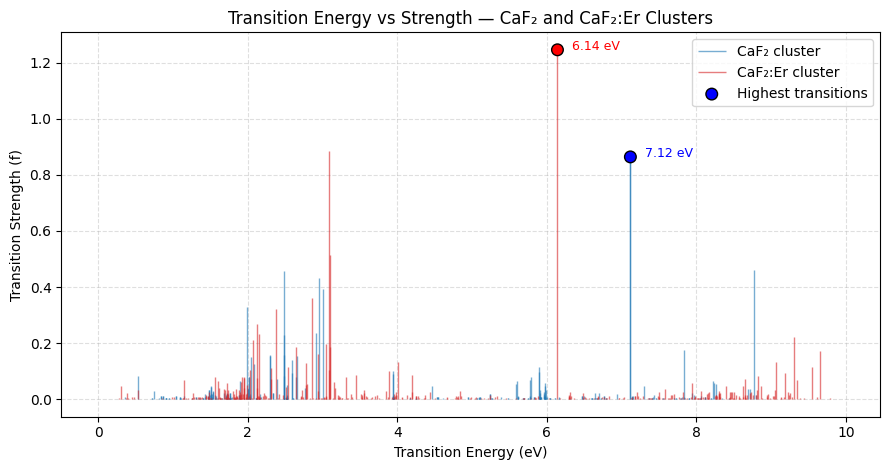

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def get_project_root():
    path = os.getcwd()
    while path != os.path.dirname(path):
        if os.path.exists(os.path.join(path, "LICENSE")) or os.path.exists(os.path.join(path, ".gitignore")):
            return path
        path = os.path.dirname(path)
    return os.getcwd()

PROJECT_ROOT = get_project_root()
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
OUT_DIR = os.path.join(PROJECT_ROOT, "spectra-results")
os.makedirs(OUT_DIR, exist_ok=True)

# === Helper function to load data ===
def load_sticks(filename):
    df = pd.read_csv(os.path.join(DATA_DIR, filename))
    cols = {c.lower().strip(): c for c in df.columns}
    energy_col = cols.get("energy(ev)") or list(df.columns)[0]
    osc_col = cols.get("oscstrength") or list(df.columns)[1]
    energies = df[energy_col].astype(float).to_numpy()
    strengths = df[osc_col].astype(float).to_numpy()
    return energies, strengths

# === Load both datasets ===
energies_caf2, strengths_caf2 = load_sticks("caf2_cluster_sticks.csv")
energies_er, strengths_er = load_sticks("caf2_er_cluster_sticks.csv")

# === Find maximum peaks ===
max_idx_caf2 = np.argmax(strengths_caf2)
max_idx_er = np.argmax(strengths_er)

print(f"CaF₂ → max f = {strengths_caf2[max_idx_caf2]:.4f} at {energies_caf2[max_idx_caf2]:.3f} eV")
print(f"CaF₂:Er → max f = {strengths_er[max_idx_er]:.4f} at {energies_er[max_idx_er]:.3f} eV")

# === Plot setup ===
plt.figure(figsize=(9, 4.8))

# Plot CaF₂
plt.vlines(energies_caf2, 0, strengths_caf2, colors="#1f77b4", alpha=0.6, linewidth=1.0, label="CaF₂ cluster")

# Plot CaF₂:Er
plt.vlines(energies_er, 0, strengths_er, colors="#d62728", alpha=0.6, linewidth=1.0, label="CaF₂:Er cluster")

# Highlight peaks
plt.scatter(
    [energies_caf2[max_idx_caf2], energies_er[max_idx_er]],
    [strengths_caf2[max_idx_caf2], strengths_er[max_idx_er]],
    color=["blue", "red"], s=70, edgecolors="k", zorder=5, label="Highest transitions"
)

# Annotate peaks
plt.text(energies_caf2[max_idx_caf2] + 0.2, strengths_caf2[max_idx_caf2],
         f"{energies_caf2[max_idx_caf2]:.2f} eV", color="blue", fontsize=9)
plt.text(energies_er[max_idx_er] + 0.2, strengths_er[max_idx_er],
         f"{energies_er[max_idx_er]:.2f} eV", color="red", fontsize=9)

# === Styling ===
plt.title("Transition Energy vs Strength — CaF₂ and CaF₂:Er Clusters")
plt.xlabel("Transition Energy (eV)")
plt.ylabel("Transition Strength (f)")
plt.legend(frameon=True)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()

out_path = os.path.join(OUT_DIR, "caf2_vs_caf2_er_sticks.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

In [3]:
#!/usr/bin/env python3
"""
CaF₂ vs CaF₂:Er TDDFT Stick Data — Normalized Gaussian-Broadened Mini Spectrum
"""

import os, sys, numpy as np, pandas as pd
from scipy.stats import skew, kurtosis

# === Gaussian peak ===
def gaussian_peak(E, f, grid, sigma=0.15):
    """Return Gaussian-broadened mini-spectrum for one transition."""
    return f * np.exp(-0.5 * ((grid - E) / sigma) ** 2)

# === Project directories ===
def get_project_root():
    path = os.getcwd()
    while path != os.path.dirname(path):
        if os.path.exists(os.path.join(path, "LICENSE")) or os.path.exists(os.path.join(path, ".gitignore")):
            return path
        path = os.path.dirname(path)
    return os.getcwd()

PROJECT_ROOT = get_project_root()
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
os.makedirs(DATA_DIR, exist_ok=True)

# === Main analyzer ===
def analyze_csv(filename: str, sigma=0.15):
    filepath = os.path.join(DATA_DIR, filename)
    if not os.path.exists(filepath):
        sys.exit(f"[ERROR] File not found: {filepath}")

    df = pd.read_csv(filepath)
    colE = [c for c in df.columns if "Energy" in c][0]
    colF = [c for c in df.columns if "Osc" in c or "f" in c][0]

    E = df[colE].astype(float).to_numpy()
    F = df[colF].astype(float).to_numpy()
    wl = 1240.0 / np.maximum(E, 1e-9)

    Σf = F.sum()
    centroid_E = (E * F).sum() / Σf if Σf > 0 else np.nan
    centroid_λ = 1240.0 / max(centroid_E, 1e-6)

    stats = {
        "Transitions": len(E),
        "Energy Range (eV)": f"{E.min():.3f} – {E.max():.3f}",
        "Energy Mean / Median": f"{E.mean():.3f} / {np.median(E):.3f}",
        "Osc Strength Min / Mean / Max": f"{F.min():.3e} / {F.mean():.3e} / {F.max():.3e}",
        "Σf (Total Strength)": f"{Σf:.6f}",
        "Centroid Energy (eV)": f"{centroid_E:.3f}",
        "Centroid Wavelength (nm)": f"{centroid_λ:.0f}",
        "Energy Skewness": f"{skew(E):.3f}",
        "Energy Kurtosis": f"{kurtosis(E):.3f}",
    }

    idx = np.argsort(F)[-10:][::-1]
    topE, topF, topWL = E[idx], F[idx], wl[idx]

    # === Gaussian-broadened intensity ===
    energy_grid = np.linspace(0, 10, 2000)
    mini_spec = [gaussian_peak(e, f, energy_grid, sigma).max() for e, f in zip(topE, topF)]
    mini_spec = np.array(mini_spec)
    mini_spec_norm = (mini_spec - mini_spec.min()) / (mini_spec.max() - mini_spec.min() + 1e-12)

    top_df = pd.DataFrame({
        "Energy (eV)": topE,
        "λ (nm)": topWL,
        "Osc. Strength (f)": topF,
        f"Gaussian Broad. I(E) [σ={sigma}, norm.]": mini_spec_norm
    })

    return stats, top_df

# === Analyze both datasets ===
stats_caf2, top_caf2 = analyze_csv("caf2_cluster_sticks.csv")
stats_er, top_er = analyze_csv("caf2_er_cluster_sticks.csv")

# === Merge tables ===
merged = pd.concat([
    top_caf2.add_prefix("CaF₂ "),
    top_er.add_prefix("CaF₂:Er ")
], axis=1)

# === Display to console ===
print("\n=== CaF₂ Statistical Summary ===")
for k, v in stats_caf2.items():
    print(f"{k:35s}: {v}")

print("\n=== CaF₂:Er Statistical Summary ===")
for k, v in stats_er.items():
    print(f"{k:35s}: {v}")

print("\n=== Top 10 Transitions with Normalized Gaussian Broadening ===")
print(merged.to_markdown(index=False))

# === Save Markdown ===
OUTPUT_MD = os.path.join(DATA_DIR, "caf2_vs_caf2_er_broadened_summary_norm.md")
with open(OUTPUT_MD, "w") as f:
    f.write("# CaF₂ vs CaF₂:Er TDDFT Stick Data — Normalized Gaussian-Broadened Intensities\n\n")

    f.write("## Statistical Overview\n\n")
    f.write("| Metric | CaF₂ | CaF₂:Er |\n|:--|:--:|:--:|\n")
    for key in stats_caf2.keys():
        f.write(f"| {key} | {stats_caf2[key]} | {stats_er[key]} |\n")

    f.write("\n## Top 10 Transitions with Normalized Gaussian Broadening (σ = 0.15 eV)\n\n")
    f.write(merged.to_markdown(index=False))


=== CaF₂ Statistical Summary ===
Transitions                        : 1292
Energy Range (eV)                  : 0.002 – 8.804
Energy Mean / Median               : 3.786 / 3.493
Osc Strength Min / Mean / Max      : 3.152e-13 / 7.540e-03 / 8.636e-01
Σf (Total Strength)                : 9.741539
Centroid Energy (eV)               : 4.465
Centroid Wavelength (nm)           : 278
Energy Skewness                    : 0.243
Energy Kurtosis                    : -1.162

=== CaF₂:Er Statistical Summary ===
Transitions                        : 1589
Energy Range (eV)                  : 0.006 – 9.958
Energy Mean / Median               : 3.782 / 3.381
Osc Strength Min / Mean / Max      : 7.096e-12 / 7.467e-03 / 1.245e+00
Σf (Total Strength)                : 11.864787
Centroid Energy (eV)               : 4.367
Centroid Wavelength (nm)           : 284
Energy Skewness                    : 0.422
Energy Kurtosis                    : -0.956

=== Top 10 Transitions with Normalized Gaussian Broadening ===


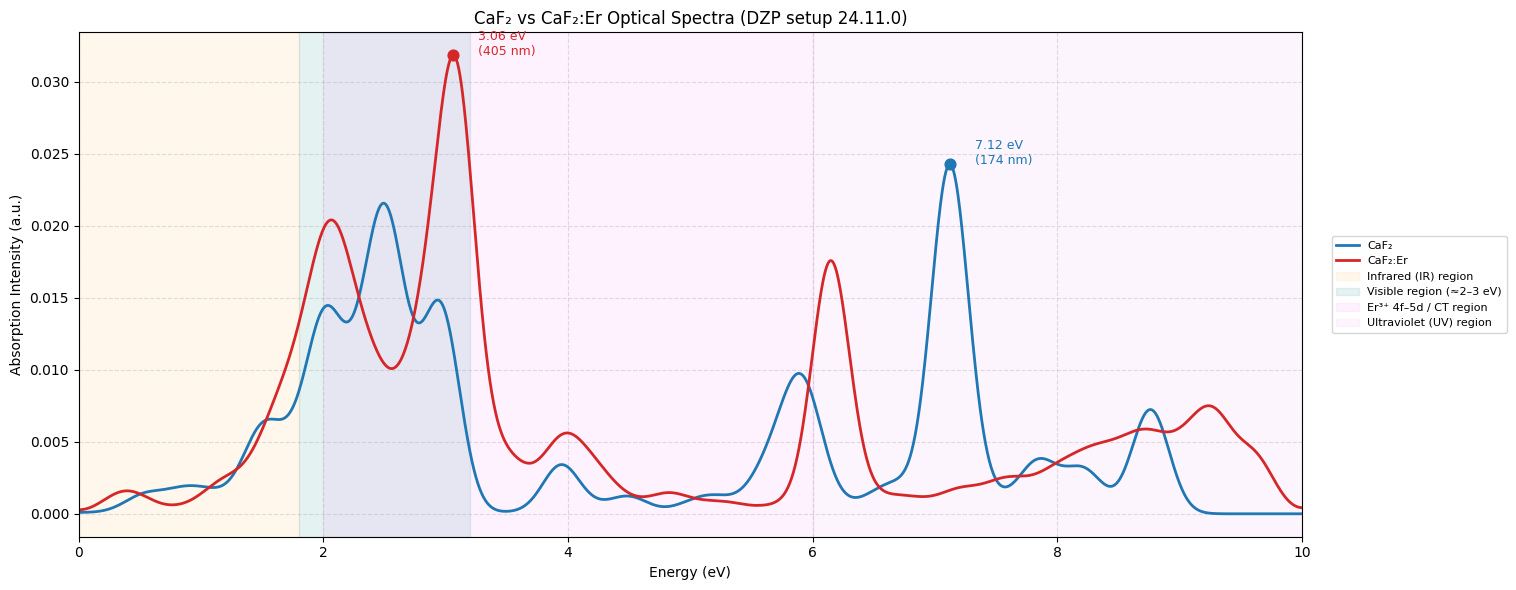

CaF₂ peak: 7.124 eV (174.1 nm)
CaF₂:Er peak: 3.062 eV (405.0 nm)


In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def get_project_root():
    path = os.getcwd()
    while path != os.path.dirname(path):
        if os.path.exists(os.path.join(path, "LICENSE")) or os.path.exists(os.path.join(path, ".gitignore")):
            return path
        path = os.path.dirname(path)
    return os.getcwd()

PROJECT_ROOT = get_project_root()
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
OUT_DIR = os.path.join(PROJECT_ROOT, "spectra-results")
os.makedirs(OUT_DIR, exist_ok=True)

# === Helper to load stick data ===
def load_sticks(filename):
    df = pd.read_csv(os.path.join(DATA_DIR, filename))
    cols = {c.lower().strip(): c for c in df.columns}
    energy_col = cols.get("energy(ev)") or list(df.columns)[0]
    osc_col = cols.get("oscstrength") or list(df.columns)[1]
    energies = df[energy_col].astype(float).to_numpy()
    strengths = df[osc_col].astype(float).to_numpy()
    return energies, strengths

# === Load both systems ===
energies_caf2, strengths_caf2 = load_sticks("caf2_cluster_sticks.csv")
energies_er, strengths_er = load_sticks("caf2_er_cluster_sticks.csv")

# === Define Gaussian broadening ===
sigma = 0.15  # eV
energy_grid = np.linspace(0, 10, 2000)

def broaden(energies, strengths, sigma, grid):
    spectrum = np.zeros_like(grid)
    for e, s in zip(energies, strengths):
        idx = np.argmin(np.abs(grid - e))
        if 0 <= idx < len(grid):
            spectrum[idx] += s
    return gaussian_filter1d(spectrum, sigma / (grid[1] - grid[0]))

spec_caf2 = broaden(energies_caf2, strengths_caf2, sigma, energy_grid)
spec_er = broaden(energies_er, strengths_er, sigma, energy_grid)

# === Identify peak positions ===
def find_peak(x, y):
    idx = np.argmax(y)
    return x[idx], y[idx]

peak_e_caf2, peak_f_caf2 = find_peak(energy_grid, spec_caf2)
peak_e_er, peak_f_er = find_peak(energy_grid, spec_er)

# === Convert to wavelength (nm) ===
def e_to_nm(e):
    return 1240 / e if e > 0 else np.nan

wl_caf2 = e_to_nm(peak_e_caf2)
wl_er = e_to_nm(peak_e_er)

# === Plot ===
plt.figure(figsize=(18, 6))

# Smooth spectra
plt.plot(energy_grid, spec_caf2, color="#1f77b4", lw=2, label="CaF₂")
plt.plot(energy_grid, spec_er, color="#d62728", lw=2, label="CaF₂:Er")

# === Optical regions (expanded for IR, NIR, UV) ===
plt.axvspan(0.0, 1.8, color='orange', alpha=0.08, label="Infrared (IR) region")
plt.axvspan(1.8, 3.2, color='teal', alpha=0.10, label="Visible region (≈2–3 eV)")
plt.axvspan(2.0, 6.0, color='magenta', alpha=0.05, label="Er³⁺ 4f–5d / CT region")
plt.axvspan(6.0, 10.0, color='violet', alpha=0.08, label="Ultraviolet (UV) region")

# === Peak markers ===
plt.scatter([peak_e_caf2], [peak_f_caf2], color="#1f77b4", s=60)
plt.scatter([peak_e_er], [peak_f_er], color="#d62728", s=60)
plt.text(peak_e_caf2 + 0.2, peak_f_caf2, f"{peak_e_caf2:.2f} eV\n({wl_caf2:.0f} nm)",
         color="#1f77b4", fontsize=9)
plt.text(peak_e_er + 0.2, peak_f_er, f"{peak_e_er:.2f} eV\n({wl_er:.0f} nm)",
         color="#d62728", fontsize=9)

# === Layout ===
plt.title("CaF₂ vs CaF₂:Er Optical Spectra (DZP setup 24.11.0)")
plt.xlabel("Energy (eV)")
plt.ylabel("Absorption Intensity (a.u.)")
plt.xlim(0, 10)
plt.grid(True, linestyle="--", alpha=0.4)

# === Legend (moved to side, vertical) ===
plt.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=True,
    fontsize=8,
    ncol=1
)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space for legend

# === Save figure ===
out_path = os.path.join(OUT_DIR, "caf2_vs_caf2_er_broadened_clean_regions.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"CaF₂ peak: {peak_e_caf2:.3f} eV ({wl_caf2:.1f} nm)")
print(f"CaF₂:Er peak: {peak_e_er:.3f} eV ({wl_er:.1f} nm)")

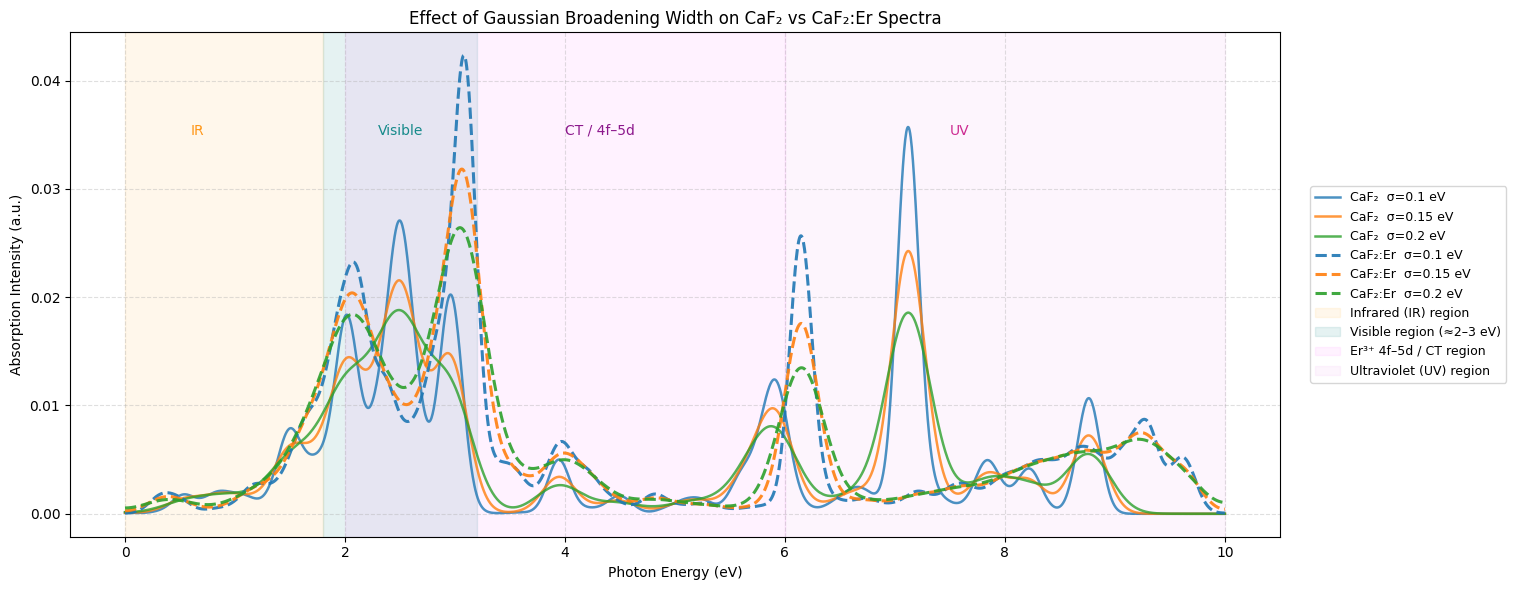

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# === Paths ===
DATA_DIR = "/Users/denniswayo/gpaw-DFT/Q-UCSpec/data"
caf2_file = os.path.join(DATA_DIR, "caf2_cluster_sticks.csv")
er_file = os.path.join(DATA_DIR, "caf2_er_cluster_sticks.csv")

# === Helper ===
def load_sticks(path):
    df = pd.read_csv(path)
    cols = {c.lower(): c for c in df.columns}
    E = df[cols['energy(ev)']].to_numpy()
    F = df[cols['oscstrength']].to_numpy()
    return E, F

E_caf2, F_caf2 = load_sticks(caf2_file)
E_er, F_er = load_sticks(er_file)

# === Energy grid ===
E_grid = np.linspace(0, 10, 2000)

def broaden(E, F, sigma, grid):
    spec = np.zeros_like(grid)
    for e, f in zip(E, F):
        idx = np.argmin(np.abs(grid - e))
        spec[idx] += f
    return gaussian_filter1d(spec, sigma / (grid[1]-grid[0]))

# === Multiple σ values ===
sigmas = [0.10, 0.15, 0.20]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

plt.figure(figsize=(18,6))

# --- CaF₂ spectra ---
for sigma, color in zip(sigmas, colors):
    spec_caf2 = broaden(E_caf2, F_caf2, sigma, E_grid)
    plt.plot(E_grid, spec_caf2, color=color, lw=1.8,
             label=f"CaF₂  σ={sigma} eV", alpha=0.8)

# --- CaF₂:Er spectra ---
for sigma, color in zip(sigmas, colors):
    spec_er = broaden(E_er, F_er, sigma, E_grid)
    plt.plot(E_grid, spec_er, color=color, lw=2.2,
             linestyle='--', label=f"CaF₂:Er  σ={sigma} eV", alpha=0.9)

# --- Highlight optical regions ---
plt.axvspan(0.0, 1.8, color='orange', alpha=0.08, label="Infrared (IR) region")
plt.axvspan(1.8, 3.2, color='teal', alpha=0.10, label="Visible region (≈2–3 eV)")
plt.axvspan(2.0, 6.0, color='magenta', alpha=0.05, label="Er³⁺ 4f–5d / CT region")
plt.axvspan(6.0, 10.0, color='violet', alpha=0.08, label="Ultraviolet (UV) region")

# --- Region labels (optional aesthetic) ---
plt.text(0.6, 0.035, "IR", color="darkorange", fontsize=10, alpha=0.9)
plt.text(2.3, 0.035, "Visible", color="teal", fontsize=10, alpha=0.9)
plt.text(4.0, 0.035, "CT / 4f–5d", color="purple", fontsize=10, alpha=0.9)
plt.text(7.5, 0.035, "UV", color="mediumvioletred", fontsize=10, alpha=0.9)

# --- Labels & vertical legend ---
plt.title("Effect of Gaussian Broadening Width on CaF₂ vs CaF₂:Er Spectra")
plt.xlabel("Photon Energy (eV)")
plt.ylabel("Absorption Intensity (a.u.)")
plt.legend(
    loc="center left",            # move legend to right side
    bbox_to_anchor=(1.02, 0.5),   # anchor it outside the main plot
    frameon=True,
    fontsize=9,
    ncol=1                        # vertical legend
)

# === Output directory ===
OUT_DIR = "/Users/denniswayo/gpaw-DFT/Q-UCSpec/spectra-results"
os.makedirs(OUT_DIR, exist_ok=True)

# === Plot adjustments ===
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # make space for legend

# === Save figure ===
outfile = os.path.join(OUT_DIR, f"caf2_vs_caf2er_broadening_full_.png")
plt.savefig(outfile, dpi=300, bbox_inches="tight")

# === Display ===
plt.show()

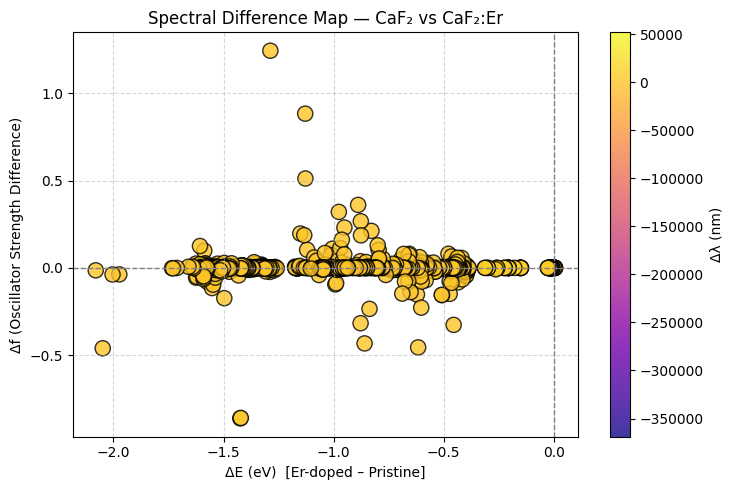

In [11]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# === Fixed universal project directories ===
PROJECT_ROOT = "/Users/denniswayo/gpaw-DFT/Q-UCSpec"
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
OUT_DIR = os.path.join(PROJECT_ROOT, "spectra-results")
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

caf2_file = os.path.join(DATA_DIR, "caf2_cluster_sticks.csv")
er_file   = os.path.join(DATA_DIR, "caf2_er_cluster_sticks.csv")
out_md    = os.path.join(DATA_DIR, "caf2_vs_caf2_er_summary_with_deltas.md")
out_png   = os.path.join(OUT_DIR, "caf2_vs_caf2_er_delta_map.png")

# === Helper to load CSV safely ===
def load_csv(fpath):
    if not os.path.exists(fpath):
        raise FileNotFoundError(f" Missing file: {fpath}")
    df = pd.read_csv(fpath)
    cols = {c.lower().strip(): c for c in df.columns}
    e_col = cols.get("energy(ev)") or list(df.columns)[0]
    f_col = cols.get("oscstrength") or list(df.columns)[1]
    E = df[e_col].astype(float).to_numpy()
    F = df[f_col].astype(float).to_numpy()
    wl = 1240.0 / np.maximum(E, 1e-9)
    return E, F, wl

# === Load both datasets ===
E1, F1, wl1 = load_csv(caf2_file)
E2, F2, wl2 = load_csv(er_file)

# === Basic stats ===
def describe(E, F):
    Σf = F.sum()
    return dict(
        N=len(E),
        Emin=np.min(E), Emax=np.max(E),
        meanE=np.mean(E), medE=np.median(E),
        meanF=np.mean(F), maxF=np.max(F),
        Σf=Σf,
        centroidE=(E*F).sum()/Σf,
        centroidλ=1240/((E*F).sum()/Σf),
        skew=skew(E), kurt=kurtosis(E)
    )

S1, S2 = describe(E1, F1), describe(E2, F2)

# === Δ-analysis ===
n = min(len(E1), len(E2))
pairs = []
for i in range(n):
    pairs.append((
        E1[i], 1240/E1[i], F1[i],
        E2[i], 1240/E2[i], F2[i],
        E2[i]-E1[i], (1240/E2[i])-(1240/E1[i]), F2[i]-F1[i]
    ))
df = pd.DataFrame(pairs, columns=["E_CaF2","λ_CaF2","f_CaF2",
                                  "E_Er","λ_Er","f_Er",
                                  "ΔE","Δλ","Δf"])

# === Markdown summary ===
with open(out_md, "w") as f:
    f.write("# CaF₂ vs CaF₂:Er Δ-Analysis Summary\n\n")
    f.write("| Metric | CaF₂ | CaF₂:Er |\n|:--|:--:|:--:|\n")
    f.write(f"| Transitions | {S1['N']} | {S2['N']} |\n")
    f.write(f"| Energy Range (eV) | {S1['Emin']:.3f}–{S1['Emax']:.3f} | {S2['Emin']:.3f}–{S2['Emax']:.3f} |\n")
    f.write(f"| Energy Mean / Median | {S1['meanE']:.3f}/{S1['medE']:.3f} | {S2['meanE']:.3f}/{S2['medE']:.3f} |\n")
    f.write(f"| Osc Strength Mean / Max | {S1['meanF']:.3e}/{S1['maxF']:.3e} | {S2['meanF']:.3e}/{S2['maxF']:.3e} |\n")
    f.write(f"| Σf (Total Strength) | {S1['Σf']:.6f} | {S2['Σf']:.6f} |\n")
    f.write(f"| Centroid Energy (eV) | {S1['centroidE']:.3f} | {S2['centroidE']:.3f} |\n")
    f.write(f"| Centroid Wavelength (nm) | {S1['centroidλ']:.0f} | {S2['centroidλ']:.0f} |\n")
    f.write(f"| Energy Skewness | {S1['skew']:.3f} | {S2['skew']:.3f} |\n")
    f.write(f"| Energy Kurtosis | {S1['kurt']:.3f} | {S2['kurt']:.3f} |\n\n")

    f.write("## Top 10 Transitions (Δ Summary)\n\n")
    f.write("| # | E(CaF₂) | λ(nm) | f | E(CaF₂:Er) | λ(nm) | f | ΔE(eV) | Δλ(nm) | Δf |\n|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|\n")
    for i,(a,b,c,d,e_,f_,g,h,j) in enumerate(pairs[:10],1):
        f.write(f"| {i} | {a:.3f} | {b:.0f} | {c:.3e} | {d:.3f} | {e_:.0f} | {f_:.3e} | {g:+.3f} | {h:+.0f} | {j:+.3e} |\n")

# === ΔE–Δf Map ===
plt.figure(figsize=(7.5,5))
sc = plt.scatter(df["ΔE"], df["Δf"], c=df["Δλ"], cmap="plasma", s=120,
                 edgecolor="k", alpha=0.8)
plt.axvline(0, color='gray', linestyle='--', lw=1)
plt.axhline(0, color='gray', linestyle='--', lw=1)
plt.colorbar(sc, label="Δλ (nm)")
plt.title("Spectral Difference Map — CaF₂ vs CaF₂:Er")
plt.xlabel("ΔE (eV)  [Er-doped – Pristine]")
plt.ylabel("Δf (Oscillator Strength Difference)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(out_png, dpi=300)
plt.show()

In [10]:
import os
import numpy as np
import pandas as pd

# === Paths ===
DATA_DIR = "/Users/denniswayo/gpaw-DFT/Q-UCSpec/data"
os.makedirs(DATA_DIR, exist_ok=True)

# === Constants ===
h = 4.135667696e-15  # eV·s
c = 2.99792458e10    # cm/s

# === Helper: Generate Scaled Optical Properties from Stick Data ===
def generate_scaled_optical(stick_file, out_file):
    df = pd.read_csv(os.path.join(DATA_DIR, stick_file))
    E = df[df.columns[0]].astype(float).to_numpy()  # Energy (eV)
    f = df[df.columns[1]].astype(float).to_numpy()  # Oscillator strength

    # --- Normalize oscillator strengths ---
    f_norm = f / np.max(f) if np.max(f) > 0 else f

    eps1 = 2 + 2.5 * np.exp(-E / 5.0)              # Real dielectric response
    eps2 = 0.5 * np.abs(np.gradient(f_norm, E))     # Imag dielectric linked to absorption
    n = np.sqrt((np.sqrt(eps1**2 + eps2**2) + eps1) / 2)
    kappa = np.sqrt((np.sqrt(eps1**2 + eps2**2) - eps1) / 2)

    # --- Absorption coefficient α (cm⁻¹) ---
    alpha = 4 * np.pi * kappa * (E * 1.60218e-19) / (h * c)
    alpha /= np.max(alpha)  # normalize to [0, 1] for scaled set

    # --- Build scaled optical dataset ---
    df_opt = pd.DataFrame({
        "Energy (eV)": E,
        "ε₁ (Real dielectric)": eps1,
        "ε₂ (Imag dielectric)": eps2,
        "n (Refractive index)": n,
        "κ (Extinction coeff)": kappa,
        "α (Absorption cm^-1)": alpha
    })

    out_path = os.path.join(DATA_DIR, out_file)
    df_opt.to_csv(out_path, index=False)
    print(f"Generated optical property dataset → {out_path}")
    print(f"   Columns: {list(df_opt.columns)}\n")
    return df_opt

generate_scaled_optical("caf2_cluster_sticks.csv", "caf2_cluster_optical_properties_scaled.csv")
generate_scaled_optical("caf2_er_cluster_sticks.csv", "caf2_er_cluster_optical_properties_scaled.csv")

Generated optical property dataset → /Users/denniswayo/gpaw-DFT/Q-UCSpec/data/caf2_cluster_optical_properties_scaled.csv
   Columns: ['Energy (eV)', 'ε₁ (Real dielectric)', 'ε₂ (Imag dielectric)', 'n (Refractive index)', 'κ (Extinction coeff)', 'α (Absorption cm^-1)']

Generated optical property dataset → /Users/denniswayo/gpaw-DFT/Q-UCSpec/data/caf2_er_cluster_optical_properties_scaled.csv
   Columns: ['Energy (eV)', 'ε₁ (Real dielectric)', 'ε₂ (Imag dielectric)', 'n (Refractive index)', 'κ (Extinction coeff)', 'α (Absorption cm^-1)']



,Energy (eV),ε₁ (Real dielectric),ε₂ (Imag dielectric),n (Refractive index),κ (Extinction coeff),α (Absorption cm^-1)
0,0.006339,4.496832,1.185489e-06,2.120574,2.795706e-07,2.510225e-11
1,0.007629,4.496188,2.222008e-07,2.120422,5.161914e-08,5.577954e-12
2,0.009243,4.495383,1.330184e-07,2.120232,2.980232e-08,3.901352e-12
3,0.010329,4.494841,2.488396e-06,2.120104,5.866593e-07,8.582479e-11
4,0.010571,4.494720,2.121925e-06,2.120076,5.004661e-07,7.492837e-11
...,...,...,...,...,...,...
1584,9.784817,2.353217,1.430043e-01,1.534727,4.658949e-02,6.456759e-03
1585,9.814195,2.351148,4.399415e-02,1.533412,1.434518e-02,1.994043e-03
1586,9.898212,2.345297,4.906343e-02,1.531520,1.601789e-02,2.245618e-03
1587,9.908264,2.344603,4.382840e-02,1.531277,1.431107e-02,2.008369e-03


In [12]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# === Paths ===
DATA_DIR = "/Users/denniswayo/gpaw-DFT/Q-UCSpec/data"
OUT_DIR = "/Users/denniswayo/gpaw-DFT/Q-UCSpec/spectra-results"
os.makedirs(OUT_DIR, exist_ok=True)

# === File mapping ===
systems = {
    "CaF2": {
        "sticks": "caf2_cluster_sticks.csv",
        "optical": "caf2_cluster_optical_properties_scaled.csv"
    },
    "CaF2:Er": {
        "sticks": "caf2_er_cluster_sticks.csv",
        "optical": "caf2_er_cluster_optical_properties_scaled.csv"
    }
}

# === Helper: Compute Stick-based Descriptors ===
def compute_spectral_descriptors(stick_path):
    df = pd.read_csv(stick_path)
    E = df[df.columns[0]].astype(float).to_numpy()
    f = df[df.columns[1]].astype(float).to_numpy()

    f_sum = np.sum(f)
    f_norm = f / f_sum if f_sum > 0 else f

    peak_intensity = np.max(f_norm)
    spectral_area = np.trapz(f_norm, E)
    mean_energy = np.average(E, weights=f_norm)
    variance = np.average((E - mean_energy)**2, weights=f_norm)

    df_desc = pd.DataFrame({
        "Energy (eV)": E,
        "OscStrength": f,
        "Normalized f": f_norm,
        "Peak Intensity": [peak_intensity]*len(E),
        "Spectral Area": [spectral_area]*len(E),
        "Mean Energy": [mean_energy]*len(E),
        "Variance": [variance]*len(E)
    })
    return df_desc

def load_optical_properties(opt_path):
    df = pd.read_csv(opt_path)

    df_opt = pd.DataFrame({
        "Energy (eV)": df["Energy (eV)"].astype(float),
        "ε₁ (Real dielectric)": df["ε₁ (Real dielectric)"],
        "ε₂ (Imag dielectric)": df["ε₂ (Imag dielectric)"],
        "n (Refractive index)": df["n (Refractive index)"],
        "κ (Extinction coeff)": df["κ (Extinction coeff)"],
        "α (Absorption cm^-1)": df["α (Absorption cm^-1)"]
    })

    return df_opt

# === Merge and Scale Separately ===
def merge_and_scale(label, stick_file, opt_file):
    stick_path = os.path.join(DATA_DIR, stick_file)
    opt_path = os.path.join(DATA_DIR, opt_file)

    df_spec = compute_spectral_descriptors(stick_path)
    df_opt = load_optical_properties(opt_path)

    df_merged = pd.merge_asof(
        df_spec.sort_values("Energy (eV)"),
        df_opt.sort_values("Energy (eV)"),
        on="Energy (eV)",
        direction="nearest"
    )

    # ---- REMOVE ALL-NAN COLUMNS (temporary until dielectric file is valid) ----
    df_merged = df_merged.dropna(axis=1, how='all')

    df_merged["System"] = label
    raw_csv = os.path.join(DATA_DIR, f"{label.lower().replace(':','_')}_qml_full_descriptors.csv")
    df_merged.to_csv(raw_csv, index=False)
    print(f"{label} raw QML descriptor dataset saved → {raw_csv}")

    # --- Scale numeric columns only ---
    numeric_cols = df_merged.select_dtypes(include=[np.number]).columns
    scaler = MinMaxScaler()
    df_scaled = df_merged.copy()
    df_scaled[numeric_cols] = scaler.fit_transform(df_merged[numeric_cols])
    scaled_csv = os.path.join(DATA_DIR, f"{label.lower().replace(':','_')}_qml_scaled_descriptors.csv")
    df_scaled.to_csv(scaled_csv, index=False)
    print(f"{label} scaled QML descriptor dataset saved → {scaled_csv}")

    # Print summary for verification
    print(f"\n Scaling summary for {label}:")
    for col in numeric_cols:
        print(f"  {col:25s} → [{df_scaled[col].min():.3f}, {df_scaled[col].max():.3f}]")

# === Run for each system separately ===
for label, paths in systems.items():
    merge_and_scale(label, paths["sticks"], paths["optical"])

CaF2 raw QML descriptor dataset saved → /Users/denniswayo/gpaw-DFT/Q-UCSpec/data/caf2_qml_full_descriptors.csv
CaF2 scaled QML descriptor dataset saved → /Users/denniswayo/gpaw-DFT/Q-UCSpec/data/caf2_qml_scaled_descriptors.csv

 Scaling summary for CaF2:
  Energy (eV)               → [0.000, 1.000]
  OscStrength               → [0.000, 1.000]
  Normalized f              → [0.000, 1.000]
  Peak Intensity            → [0.000, 0.000]
  Spectral Area             → [0.000, 0.000]
  Mean Energy               → [0.000, 0.000]
  Variance                  → [0.000, 0.000]
  ε₁ (Real dielectric)      → [0.000, 1.000]
  ε₂ (Imag dielectric)      → [0.000, 1.000]
  n (Refractive index)      → [0.000, 1.000]
  κ (Extinction coeff)      → [0.000, 1.000]
  α (Absorption cm^-1)      → [0.000, 1.000]
CaF2:Er raw QML descriptor dataset saved → /Users/denniswayo/gpaw-DFT/Q-UCSpec/data/caf2_er_qml_full_descriptors.csv
CaF2:Er scaled QML descriptor dataset saved → /Users/denniswayo/gpaw-DFT/Q-UCSpec/data/c

In [ ]:
#!/usr/bin/env python3
# Uses GPAW linear response to produce eps1/eps2, n, k, alpha and a tidy CSV.

import os, numpy as np, pandas as pd
from gpaw import GPAW
from gpaw.response.df import DielectricFunction  # GPAW 22+ / 25.x

# --------- CONFIG (edit these) ----------
GPW_FILE   = "caf2_cluster_fd.gpw"  # ground-state checkpoint
#GPW_FILE   = "caf2_er_cluster_fd.gpw"  # ground-state checkpoint
SYSTEM_TAG = "caf2"                 # used in output filename
#SYSTEM_TAG = "caf2_er"                 # used in output filename
DATA_DIR   = "/Users/denniswayo/gpaw-DFT/Q-UCSpec/data"

# Frequency grid / resolution
WMAX_eV = 10.0                      # up to 10 eV as in your plots
NPTS    = 2000                      # dense grid for smooth spectra
ETA_eV  = 0.15                      # damping/broadening (matches your σ)
ECUT_eV = 60                        # response plane-wave cutoff (tune)
# ---------------------------------------

os.makedirs(DATA_DIR, exist_ok=True)

# Load ground-state calculator
calc = GPAW(GPW_FILE)

# Build dielectric function object
df = DielectricFunction(
    calc,
    eta=ETA_eV,
    ecut=ECUT_eV
)

# Frequency grid in Hartree (GPAW uses Ha internally)
eV_to_Ha = 1/27.211386245988
w_w = np.linspace(0.0, WMAX_eV, NPTS) * eV_to_Ha

# Compute macroscopic ε(ω) at q→0 for x,y,z and average
eps_x = df.get_macroscopic_dielectric_constant('x', w_w)
eps_y = df.get_macroscopic_dielectric_constant('y', w_w)
eps_z = df.get_macroscopic_dielectric_constant('z', w_w)

# Average (isotropic cluster / polycrystalline assumption)
eps = (eps_x + eps_y + eps_z) / 3.0

# Split real/imag
eps1 = np.real(eps)
eps2 = np.imag(eps)

# Derive optical indices
# n = sqrt( (|eps|+eps1)/2 ), k = sqrt( (|eps|-eps1)/2 )
abs_eps = np.sqrt(eps1**2 + eps2**2)
n = np.sqrt(0.5*(abs_eps + eps1))
k = np.sqrt(0.5*(abs_eps - eps1))

# Convert frequency to energy (eV) and wavelength (nm)
E_eV = w_w / eV_to_Ha
h_c_eVnm = 1239.841984 # eV·nm
lam_nm = h_c_eVnm / np.maximum(E_eV, 1e-9)

# Absorption coefficient α(ω) in cm^-1:
# α = 4πk / λ  (λ in cm). Here λ[nm] → λ[cm] = λ[nm]*1e-7
alpha_cm = 4*np.pi*k / (lam_nm*1e-7)

# Save CSV in your pipeline’s naming
out_csv = os.path.join(DATA_DIR, f"{SYSTEM_TAG}_cluster_optical_properties_scaled.csv")
pd.DataFrame({
    "Energy(eV)": E_eV,
    "ε1": eps1,
    "ε2": eps2,
    "n": n,
    "k": k,
    "alpha(cm^-1)": alpha_cm,
}).to_csv(out_csv, index=False)

print(f"Wrote dielectric/optical spectrum → {out_csv}")
print(f"Grid: 0 – {WMAX_eV:.1f} eV, {NPTS} pts, η={ETA_eV} eV, ecut={ECUT_eV} eV")